# Renormalization Demo

Here is a demonstration of the renormalization-based method for finding an appropriate number of topics.
Several datasets are used:

* [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/)
* Some other (TODO)
* Maybe another one (TODO)

In [ ]:
# General imports

import os

from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
# Making `topnum` module visible for Python

import sys

sys.path.insert(0, '..')

In [ ]:
# Optimal number of topics

from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.search_methods import RenormalizationMethod
from topnum.search_methods.renormalization_method import (
    ENTROPY_MERGE_METHOD,
    PHI_RENORMALIZATION_MATRIX,
)

## Data

In the folder below must reside necessary data files in Vowpal Wabbit format.
The example presented in [Making-Decorrelation-and-Topic-Selection-Friends.ipynb](https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/demos/Making-Decorrelation-and-Topic-Selection-Friends.ipynb) (i.e. the first part about data exploration till writing vw.txt / dataset.csv files) was used as a preprocessing pipeline.

In [ ]:
DATA_FOLDER_PATH = 'data'

In [ ]:
os.listdir(DATA_FOLDER_PATH)

['_dataset_9_075hcj',
 '_dataset_soax33u6',
 '_dataset__vihf9m4',
 '_dataset_1tmbxnbt',
 'twenty_newsgroups__natural_order.csv',
 'twenty_newsgroups__vw__natural_order.txt']

In [ ]:
vw_file_path = os.path.join(
    DATA_FOLDER_PATH,
    'twenty_newsgroups__vw__natural_order.txt'
)

Checking if all OK with data, what modalities does the collection have.

In [ ]:
! head -n 7 $vw_file_path

102994 |@text enlighten bricklin bumper funky
51861 |@text upgraded oscillator poll detailing attained sink summarizing poll
51879 |@text ghost sooo sooner picking powerbook dirt powerbook appearence macleak powerbook swing yea solicit subjective breifly hellcat premium willis ecn purdue purdue
60880 |@text std std baker suchlike introduce liftoff
54525 |@text rigidly allegedly presenting evidently
58080 |@text bouncing probs sean debra sharon accidentally delete
60249 |@text controler burst burst burst burst esdi sumex aim txt salesperson burst synchronous


Defining a text collection entity, which is to be passed to topic number search method later:

In [ ]:
text_collection = VowpalWabbitTextCollection(
    vw_file_path,
    main_modality='@text',
    modalities=['@text']
)

The searching method itself.
It has several parameters: some are specific for the renormalization approach, some are common for all the search methods presented in `topnum` module.

In [ ]:
optimizer = RenormalizationMethod(
    merge_method = ENTROPY_MERGE_METHOD,
    matrix_for_renormalization = PHI_RENORMALIZATION_MATRIX,
    threshold_factor = 2.0,
    max_num_topics = 100,       # number of topics in one model
    num_fit_iterations = 100,   # 100 or 200 surely might be enough
    num_restarts = 3            # number of models for averaging
)

Fulfilling the search:

In [ ]:
%%time

optimizer.search_for_optimum(text_collection)

  0%|          | 0/3 [00:00<?, ?it/s]

/home/vasiliyalekseev/miniconda/lib/python3.7/site-packages/topicnet/cooking_machine/dataset.py:371: UserWarning: Attempted to use batches for different dataset.Overwriting batches in data/_dataset_copuy17i/dataset_batches
  warnings.warn(W_DIFF_BATCHES_1 + W_DIFF_BATCHES_2.format(batch_vectorizer_path))


100%|██████████| 3/3 [11:34<00:00, 231.43s/it]
CPU times: user 15min 17s, sys: 5.68 s, total: 15min 23s
Wall time: 11min 34s


The search method's result may be accessed as `optimizer._result`.
Let's see what is available here:

In [ ]:
list(optimizer._result.keys())

['optimum',
 'optimum_std',
 'num_topics_values',
 'energy_values',
 'snannon_entropy_values',
 'renyi_entropy_values',
 'num_topics_values_std',
 'energy_values_std',
 'snannon_entropy_values_std',
 'renyi_entropy_values_std']

Point estimate of the number of topics and standard deviation (std) over the restarts (`num_restarts`):

In [ ]:
result_key_optimum = 'optimum'
result_key_optimum_std = 'optimum_std'

optimum = optimizer._result['optimum']
optimum_std = optimizer._result['optimum_std']

print(
    f'Optimum: {optimizer._result[result_key_optimum]} topics.' +
    f' Std: {optimizer._result[result_key_optimum_std]}'
)

Optimum: 11.0 topics. Std: 0.0


There are also some metrics calculated for each model.
Let's look at `renyi_entropy_values`: by assumption which were made in the papers referenced in the [repository](https://github.com/machine-intelligence-laboratory/OptimalNumberOfTopics/tree/master), the lower the entropy, the more stable the model.
Thus, looking at entropy values for different number of topics, one may find the best such number, which makes the model the most stable.

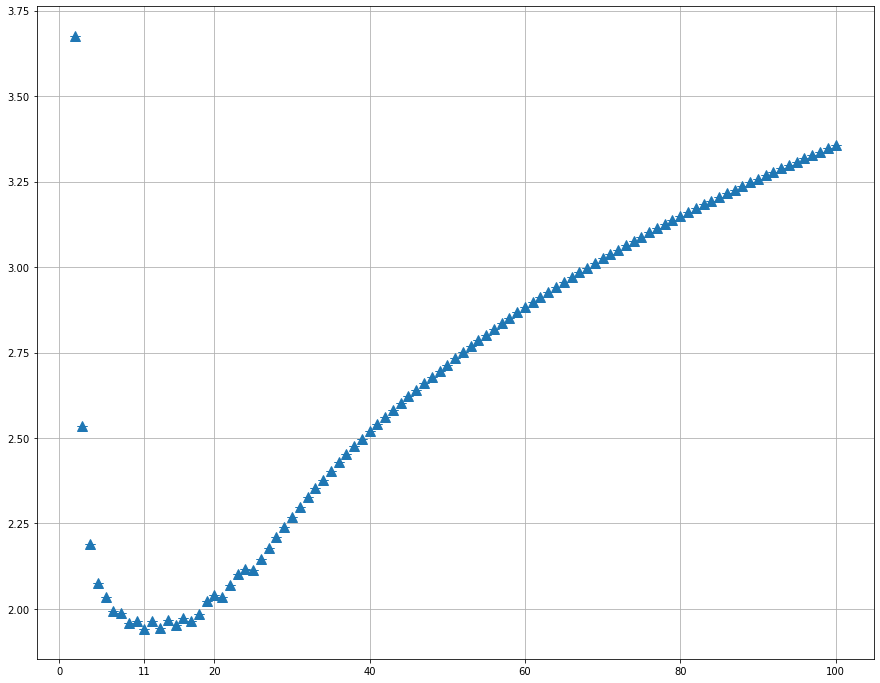

In [ ]:
result_key_number_of_topics = 'num_topics_values'
result_key_mertic = 'renyi_entropy_values'
result_key_metric_std = 'renyi_entropy_values_std'


fig, ax = plt.subplots(1, 1, figsize=(15, 12))


ax.errorbar(
    x=optimizer._result[result_key_number_of_topics],
    y=optimizer._result[result_key_mertic],
    yerr=optimizer._result[result_key_metric_std],
    linestyle='None',
    marker='^',
    markersize=10,
    capsize=5
)

# Also making the optimal number visible on X axis

xlim = ax.get_xlim()
ax.set_xticks(list(ax.get_xticks()) + [optimizer._result[result_key_optimum]])
ax.set_xlim(xlim)

ax.grid(True)

plt.show()

So, the number of topics appeared to be $11$.
Worth admitting that this is a bit far from the expected number $20$, although, in order of magnitude, the values coincide.